# TP3: Optimisation : Implémentation et Evaluation
- Maël Reynaud
- Alexandre Devaux-Rivière

### Import de la classe Tensor depuis le dernier TP (TP2)

In [1]:
class Tensor:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, [self, other], '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"

        out = Tensor(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward

        return out


    def build_topo(self, visited=None, topo=None):
        if self not in visited:
            visited.add(self)
            for child in self._prev:
                child.build_topo(visited=visited, topo=topo)
            topo.append(self)
        return topo

    def backward(self):
        topo = []
        visited = set()
        topo = self.build_topo(topo=topo, visited=visited)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad})"

### Travail pour le TP3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import List, Dict
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split

np.random.seed(0)

## Préparation des jeux de données synthétiques pour l'évaluation

### Données linaires

Le jeu de données linéaire est généré à partir d’une relation linéaire entre les variables x et y avec l’ajout d’un bruit gaussien.

In [3]:
n_samples = 100
x_linear = np.linspace(-10, 10, n_samples)
y_linear = 3 * x_linear + 5 + np.random.normal(0, 2, n_samples)

### Données non linéaires

Le jeu de données non linéaire est basé sur une relation quadratique entre x et y avec un bruit ajouté.

In [4]:
y_nonlinear = 0.5 * x_linear **2 - 4 * x_linear + np.random.normal(0, 5, n_samples)

## Implémentation des algorithmes

Préparation de la classe abstraite `Optimiseur` pour l'implémentation de nos optimiseurs customisés. On y retrouve une méthode `step()` à override, et une méthode `zero_grad()` utilisée pour remettre les gradients à 0 après chaque itération d'optimisation.

In [5]:
class Optimizer(ABC):
    def __init__(self, params: List[Tensor], lr: float):
        self.params = params
        self.lr = lr

    @abstractmethod
    def step(self):
        pass

    def zero_grad(self):
        for param in self.params:
            param.grad = 0

### Préparation de l'évaluation de nos différentes implémentations

Le `LinearModel` représente un Layer Perceptron classique, qui nous permettra de comparer la convergence de nos optimiseurs avec ceux de PyTorch sur les jeux de données.

In [6]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))

    def forward(self, x):
        return self.W * x + self.b

Nous construisons ensuite la fonction `test_optimizer()` pour évaluer l'optimiseur donné en paramètre. 

In [7]:
def test_optimizer(optim: Optimizer, torch_optim: torch.optim.Optimizer, optim_parameters: Dict):
    W = Tensor(1.0)
    b = Tensor(0.0)
    torch_model = LinearModel()

    optimizer = optim([W, b], **optim_parameters)
    torch_optimizer = torch_optim(torch_model.parameters(), **optim_parameters)

    print("Linear dataset (3 * x + 5)")
    for _ in range(100):
        for x, y in zip(x_linear, y_linear):
            loss = (y - (W * x + b)) ** 2
            torch_loss = (y - torch_model(x)) ** 2

            optimizer.zero_grad()
            torch_optimizer.zero_grad()

            loss.backward()
            torch_loss.backward()

            optimizer.step()
            torch_optimizer.step()

    print(f"[OURS] W : {W.data}, b : {b.data}")
    print(f"[PYTORCH] W : {torch_model.W.data}, b : {torch_model.b.data}")


    W = Tensor(1.0)
    b = Tensor(0.0)
    torch_model = LinearModel()

    optimizer = optim([W, b], **optim_parameters)
    torch_optimizer = torch_optim(torch_model.parameters(), **optim_parameters)

    print("\nNon linear dataset (0.5 * x^2 - 4 * x)")
    for _ in range(100):
        for x, y in zip(x_linear, y_nonlinear):
            loss = (y - (W * x + b)) ** 2
            torch_loss = (y - torch_model(x)) ** 2

            optimizer.zero_grad()
            torch_optimizer.zero_grad()

            loss.backward()
            torch_loss.backward()

            optimizer.step()
            torch_optimizer.step()

    print(f"[OURS] W : {W.data}, b : {b.data}")
    print(f"[PYTORCH] W : {torch_model.W.data}, b : {torch_model.b.data}")

### Stochastic Gradient Descent (SGD)

On retrouvera dans la case suivante l'implémentation de l'optimiseur `SGD`, qui suit la formule :

$$\theta_{i + 1} := \theta_i - \eta \nabla_\theta L(\theta_t)$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params: List[Tensor], lr: float = 0.01):
        super().__init__(params=params, lr=lr)

    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

In [9]:
test_optimizer(SGD, torch.optim.SGD, {"lr": 0.001})

Linear dataset (3 * x + 5)
[OURS] W : 3.1124139870722645, b : 4.931713920861934
[PYTORCH] W : 3.1124141216278076, b : 4.931710720062256

Non linear dataset (0.5 * x^2 - 4 * x)
[OURS] W : -0.7479125849883421, b : 13.664536448952166
[PYTORCH] W : -0.7479138374328613, b : 13.664549827575684


On retrouve bien les mêmes résultats que ceux de l'implémentation du `SGD` de PyTorch.

### Root Mean Square Propagation (RMSProp)

On retrouvera dans la case suivante l'implémentation de l'optimiseur `RMSProp`. Nous avons choisi de suivre la même implémentation que celle de Pytorch plutôt que celle du sujet, pour pouvoir comparer nos résultats :

$$E[g^2]_t = \alpha E[g^2]_{t-1} + (1 - \alpha) \nabla_\theta L(\theta_t)^2$$
$$\theta_{t+1} := \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} (\nabla_\theta L(\theta_t) + \lambda \theta_t)$$

In [10]:
class RMSProp(Optimizer):
    def __init__(self, params: List[Tensor], lr: float = 0.001, weight_decay: float = 0.9, alpha: float = 0.99, eps: int = 1e-8):
        super().__init__(params=params, lr=lr)
        self.weight_decay = weight_decay
        self.v = [0] * len(params)
        self.alpha = alpha
        self.eps = eps

    def step(self):
        for i, param in enumerate(self.params):
            gt = param.grad + self.weight_decay * param.data
            self.v[i] = self.alpha * self.v[i] + (1 - self.alpha) * (param.grad ** 2)
            param.data -= (self.lr * gt) / (np.sqrt(self.v[i]) + self.eps)

In [11]:
test_optimizer(RMSProp, torch.optim.RMSprop, {"lr": 0.001, "weight_decay": 0.9, "alpha": 0.99, "eps": 1e-8})

Linear dataset (3 * x + 5)
[OURS] W : 2.9699739947949975, b : 3.4696535126733967
[PYTORCH] W : 2.970080852508545, b : 3.521855354309082

Non linear dataset (0.5 * x^2 - 4 * x)
[OURS] W : -2.681837225663783, b : 4.731417453278267
[PYTORCH] W : -2.684575080871582, b : 4.821386814117432


On retrouve bien les mêmes résultats que ceux de l'implémentation du `RMSProp` de pytorch, bien qu'on ait des différences minimes sur les biais.

### Adagrad

On retrouvera dans la case suivante l'implémentation de l'optimiseur `Adagrad`, qui suit la formule :

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \nabla_\theta L(\theta_t)$$


In [12]:
class Adagrad(Optimizer):
    def __init__(self , params: List[Tensor], lr: float = 0.01):
        super().__init__(params=params, lr=lr)
        self.G = [np.zeros_like(param.data) for param in params]
        self.epsilon = 1e-8

    def step(self):
        for index, param in enumerate(self.params):
            self.G[index] += param.grad ** 2
            coef = np.sqrt(self.G[index]) + self.epsilon
            param.data -= (self.lr / coef) * param.grad

In [13]:
test_optimizer(Adagrad, torch.optim.Adagrad, {"lr": 0.001})

Linear dataset (3 * x + 5)
[OURS] W : 1.1379994326592422, b : 0.07407535004631868
[PYTORCH] W : 1.1380008459091187, b : 0.07407517731189728

Non linear dataset (0.5 * x^2 - 4 * x)
[OURS] W : 0.8920318490186844, b : 0.08891015717408494
[PYTORCH] W : 0.8920310735702515, b : 0.08890986442565918


On retrouve bien les mêmes résultats que ceux de l'implémentation du `Adagrad` de pytorch, qui sont d'ailleurs médiocre.

### Adam

On retrouvera dans la case suivante l'implémentation de l'optimiseur `Adam`. Nous avons encore une fois choisi de suivre la même implémentation que celle de Pytorch plutôt que celle du sujet, pour pouvoir comparer nos résultats :

$$gt = \nabla_\theta L(\theta_t) + \lambda \theta_t$$
$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) gt$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) gt^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

In [14]:
class Adam(Optimizer):
    def __init__(self, params: list, lr: float = 0.001, betas: float = (0.9, 0.999), eps: float = 1e-8):
        super().__init__(params=params, lr=lr)
        self.timestep = 1
        self.epsilon = eps
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.m = [np.zeros_like(param.data) for param in params]
        self.v = [np.zeros_like(param.data) for param in params]

    def step(self):
        for index, param in enumerate(self.params):
            self.m[index] = self.beta1 * self.m[index] + (1 - self.beta1) * param.grad
            self.v[index] = self.beta2 * self.v[index] + (1 - self.beta2) * (param.grad ** 2)
            mhat = self.m[index] / (1 - self.beta1 ** self.timestep)
            vhat = self.v[index] / (1 - self.beta2 ** self.timestep)
            coef = np.sqrt(vhat) + self.epsilon
            param.data -= self.lr * mhat / coef
        self.timestep += 1

In [15]:
test_optimizer(Adam, torch.optim.Adam, {"lr": 0.001, "betas": (0.9, 0.999), "eps": 1e-08})

Linear dataset (3 * x + 5)
[OURS] W : 2.974818069941666, b : 4.70047297094164
[PYTORCH] W : 2.974820613861084, b : 4.700463771820068

Non linear dataset (0.5 * x^2 - 4 * x)
[OURS] W : -2.8413365377254745, b : 4.957100575280201
[PYTORCH] W : -2.841322422027588, b : 4.957064628601074


On retrouve bien les mêmes résultats que ceux de l'implémentation du `Adam` de pytorch.

### AdamW

On retrouvera dans la case suivante l'implémentation de l'optimiseur `AdamW`. Nous avons une fois de plus choisi de suivre la même implémentation que celle de Pytorch plutôt que celle du sujet, pour pouvoir comparer nos résultats :

$$gt = \nabla_\theta L(\theta_t)$$
$$\theta_{t+1} = \theta - \eta\lambda\theta$$
$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) gt$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) gt^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_{t+1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

In [16]:
class AdamW(Optimizer):
    def __init__(self, params: list, lr: float = 0.001, betas: float = (0.9, 0.999), eps: float = 1e-8, weight_decay: float = 0.01):
        super().__init__(params=params, lr=lr)
        self.timestep = 1
        self.epsilon = eps
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.weight_decay = weight_decay
        self.m = [np.zeros_like(param.data) for param in params]
        self.v = [np.zeros_like(param.data) for param in params]

    def step(self):
        for index, param in enumerate(self.params):
            theta_t = param.data - (self.lr * self.weight_decay * param.data)
            self.m[index] = self.beta1 * self.m[index] + (1 - self.beta1) * param.grad
            self.v[index] = self.beta2 * self.v[index] + (1 - self.beta2) * (param.grad ** 2)
            mhat = self.m[index] / (1 - self.beta1 ** self.timestep)
            vhat = self.v[index] / (1 - self.beta2 ** self.timestep)
            coef = np.sqrt(vhat) + self.epsilon
            param.data = theta_t - self.lr * mhat / coef
        self.timestep += 1

In [17]:
test_optimizer(AdamW, torch.optim.AdamW, {"lr": 0.001, "betas": (0.9, 0.999), "eps": 1e-08, "weight_decay": 0.01})

Linear dataset (3 * x + 5)
[OURS] W : 2.9617312299916896, b : 4.58524979173881
[PYTORCH] W : 2.9617233276367188, b : 4.5850982666015625

Non linear dataset (0.5 * x^2 - 4 * x)
[OURS] W : -2.7546940277644816, b : 4.738400652882132
[PYTORCH] W : -2.7545793056488037, b : 4.7381744384765625


On retrouve bien les mêmes résultats que ceux de l'implémentation du `AdamW` de pytorch.

## Evaluation des Optimiseur

### Fonctions de Perte

On définit ici les 2 fonctions de perte du sujet, desquelles nous allons essayer d'optimiser le paramètre **x**.

In [18]:
def f(x):
    return (x - 2)**2

def f_nonconvexe(x):
    return 3*x**2 - 2*x

### Expérimentation

Dans la fonction *eval_optim*, on teste tous les optimiseurs qu'on a définit jusqu'ici sur les fonctions convexe et non convexe à optimiser.

In [19]:
def eval_optim():
    n_iterations = 500
    learning_rate = 0.01

    # store final results
    results = {
        'convex': {'SGD': [], 'RMSProp': [], 'Adagrad': [], 'Adam': [], 'AdamW': []},
        'nonconvex': {'SGD': [], 'RMSProp': [], 'Adagrad': [], 'Adam': [], 'AdamW': []}
    }

    optimizers = {
        'SGD': (SGD, {'lr': learning_rate}),
        'RMSProp': (RMSProp, {'lr': learning_rate, 'weight_decay': 0.9, 'alpha': 0.99, 'eps': 1e-8}),
        'Adagrad': (Adagrad, {'lr': learning_rate}),
        'Adam': (Adam, {'lr': learning_rate, 'betas': (0.9, 0.999), 'eps': 1e-8}),
        'AdamW': (AdamW, {'lr': learning_rate, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 0.01})
    }

    # convex
    print("===== Optimizers evaluation on convex function f(x) = (x - 2)**2 =====")
    for name, (opt_class, params) in optimizers.items():
        x = Tensor(5.0)
        optimizer = opt_class([x], **params)

        print(f"\nOptimizer: {name}")
        for i in range(n_iterations):
            loss = f(x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            results['convex'][name].append(x.data)
            if (i + 1) % 20 == 0:
                print("├──", end='') if (i + 1) != n_iterations else print("└──", end='')
                print(f"Iteration {i + 1}: x = {x.data:.4f}, loss = {loss.data:.4f}")

    # nonconvex
    print("\n===== Evaluating optimizers on non-convex function f(x) = 3x**2 - 2x =====")
    for name, (opt_class, params) in optimizers.items():
        x = Tensor(0.0)
        optimizer = opt_class([x], **params)

        print(f"\nOptimizer: {name}")
        for i in range(n_iterations):
            loss = f_nonconvexe(x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            results['nonconvex'][name].append(x.data)
            if (i + 1) % 20 == 0:
                print("├──", end='') if (i + 1) != n_iterations else print("└──", end='')
                print(f"Iteration {i + 1}: x = {x.data:.4f}, loss = {loss.data:.4f}")

    return results

La fonction *plot_optimisation_results* va nous permettre d'afficher des courbes modélisants l'optimisation des fonctions avec chaque optimiseurs. 

In [20]:
def plot_optimization_results(results):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot convex results
    for optimizer, values in results['convex'].items():
        ax1.plot(values, label=optimizer)
    ax1.set_title('Convex function optimization')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('x value')
    ax1.axhline(y=2, color='r', linestyle='--', label='Optimal x=2', alpha=0.4)
    ax1.legend()
    ax1.grid(True)

    # plot nonconvex results
    for optimizer, values in results['nonconvex'].items():
        ax2.plot(values, label=optimizer)
    ax2.set_title('Non-convex function optimization')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('x value')
    ax2.axhline(y=1/3, color='r', linestyle='--', label='Optimal x=1/3', alpha=0.4)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [21]:
res = eval_optim()

===== Optimizers evaluation on convex function f(x) = (x - 2)**2 =====

Optimizer: SGD
├──Iteration 20: x = 4.0028, loss = 4.1767
├──Iteration 40: x = 3.3371, loss = 1.8616
├──Iteration 60: x = 2.8927, loss = 0.8297
├──Iteration 80: x = 2.5959, loss = 0.3698
├──Iteration 100: x = 2.3979, loss = 0.1648
├──Iteration 120: x = 2.2656, loss = 0.0735
├──Iteration 140: x = 2.1773, loss = 0.0327
├──Iteration 160: x = 2.1184, loss = 0.0146
├──Iteration 180: x = 2.0790, loss = 0.0065
├──Iteration 200: x = 2.0528, loss = 0.0029
├──Iteration 220: x = 2.0352, loss = 0.0013
├──Iteration 240: x = 2.0235, loss = 0.0006
├──Iteration 260: x = 2.0157, loss = 0.0003
├──Iteration 280: x = 2.0105, loss = 0.0001
├──Iteration 300: x = 2.0070, loss = 0.0001
├──Iteration 320: x = 2.0047, loss = 0.0000
├──Iteration 340: x = 2.0031, loss = 0.0000
├──Iteration 360: x = 2.0021, loss = 0.0000
├──Iteration 380: x = 2.0014, loss = 0.0000
├──Iteration 400: x = 2.0009, loss = 0.0000
├──Iteration 420: x = 2.0006, loss = 

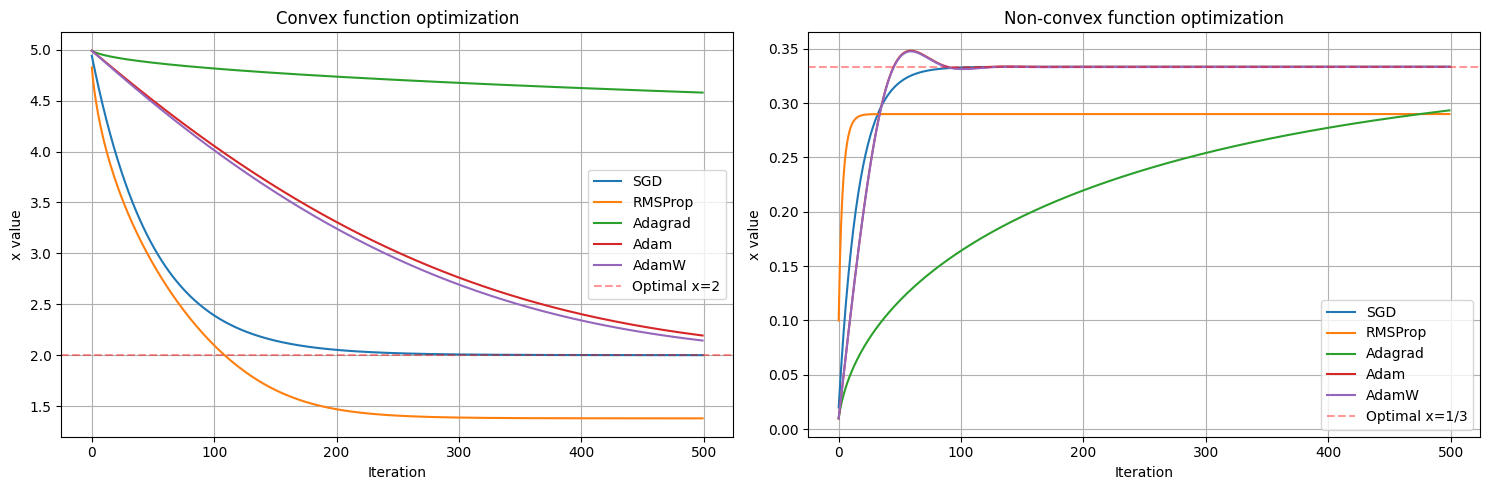

In [22]:
plot_optimization_results(res)

On remarque pour l'optmisation de la fonction **convexe** que l'optimiseur `Adagrad` converge extrêmement lentement vers la solution idéale (2), tandis que `RMSProp` dépasse quant à lui la valeur optimale et n'arrive pas à revenir sur son erreur. `SGD`, `Adam` et `AdamW` arrive eux facilement à la solution optimale.

Pour l'optimisation de la fonction **non-convexe**, tous les optimiseurs arrivent à converger à la valeur optimale ou à ses alentours, on retrouve une fois de plus que les algorithmes `SGD`, `Adam` et `AdamW` converge rapidement à la solution optimale.

## Implémentation de réseau de neurones

### Définition du modèle

In [23]:
def func_nn(x, W1: Tensor, b1: Tensor, W2: Tensor, b2: Tensor):
    h1 = W1 * x + b1
    y = W2 * h1 + b2
    return y

def mse(y: Tensor, y_hat: Tensor):
    return (y - y_hat) ** 2

### Entraînement du réseau

Dans la fonction *eval_nn_optim*, on va optimiser un réseau de neurones sur les données **x_linear** et **y_linear** avec tous les optimiseurs vu jusqu'ici.

In [24]:
def eval_nn_optim():
    # init, current data is ignored
    W1 = Tensor(0.0)
    b1 = Tensor(0.0)
    W2 = Tensor(0.0)
    b2 = Tensor(0.0)

    n_epochs = 100
    learning_rate = 0.001

    results = {
        'SGD': [],
        'RMSProp': [],
        'Adagrad': [],
        'Adam': [],
        'AdamW': []
    }

    optimizers = {
        'SGD': (SGD, {'lr': learning_rate}),
        'RMSProp': (RMSProp, {'lr': learning_rate, 'weight_decay': 0.9, 'alpha': 0.99, 'eps': 1e-8}),
        'Adagrad': (Adagrad, {'lr': learning_rate}),
        'Adam': (Adam, {'lr': learning_rate, 'betas': (0.9, 0.999), 'eps': 1e-8}),
        'AdamW': (AdamW, {'lr': learning_rate, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 0.01})
    }

    for name, (opt_class, params) in optimizers.items():
        # init -> random network parameters
        W1.data = np.random.randn()
        b1.data = np.random.randn()
        W2.data = np.random.randn()
        b2.data = np.random.randn()

        optimizer = opt_class([W1, b1, W2, b2], **params)
        print(f"\nTraining with {name}")

        epoch_losses = []
        for epoch in range(n_epochs):
            epoch_loss = 0

            for x, y in zip(x_linear, y_linear):
                y_pred = func_nn(x, W1, b1, W2, b2)
                loss = mse(y, y_pred)

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += float(loss.data)

            avg_epoch_loss = epoch_loss / len(x_linear)
            epoch_losses.append(avg_epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{n_epochs} | loss = {avg_epoch_loss:.4f}")

        results[name] = epoch_losses

    return results

La fonction *plot_nn_results* va nous permettre d'observer la courbe de la loss avec chacun des optimiseurs.

In [25]:
def plot_nn_results(results):
    plt.figure(figsize=(10, 6))
    for optimizer, losses in results.items():
        plt.plot(losses, label=optimizer)

    plt.title('Neural network training loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE (log scale)')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

In [26]:
results = eval_nn_optim()


Training with SGD
Epoch 10/100 | loss = 5.4500
Epoch 20/100 | loss = 5.3377
Epoch 30/100 | loss = 5.3171
Epoch 40/100 | loss = 5.3123
Epoch 50/100 | loss = 5.3112
Epoch 60/100 | loss = 5.3110
Epoch 70/100 | loss = 5.3110
Epoch 80/100 | loss = 5.3110
Epoch 90/100 | loss = 5.3110
Epoch 100/100 | loss = 5.3110

Training with RMSProp
Epoch 10/100 | loss = 155.0642
Epoch 20/100 | loss = 30.9458
Epoch 30/100 | loss = 12.9910
Epoch 40/100 | loss = 6.6829
Epoch 50/100 | loss = 4.9541
Epoch 60/100 | loss = 4.5667
Epoch 70/100 | loss = 4.4642
Epoch 80/100 | loss = 4.4265
Epoch 90/100 | loss = 4.4056
Epoch 100/100 | loss = 4.3899

Training with Adagrad
Epoch 10/100 | loss = 268.5064
Epoch 20/100 | loss = 263.7868
Epoch 30/100 | loss = 260.1142
Epoch 40/100 | loss = 256.9748
Epoch 50/100 | loss = 254.1747
Epoch 60/100 | loss = 251.6152
Epoch 70/100 | loss = 249.2382
Epoch 80/100 | loss = 247.0059
Epoch 90/100 | loss = 244.8923
Epoch 100/100 | loss = 242.8783

Training with Adam
Epoch 10/100 | los

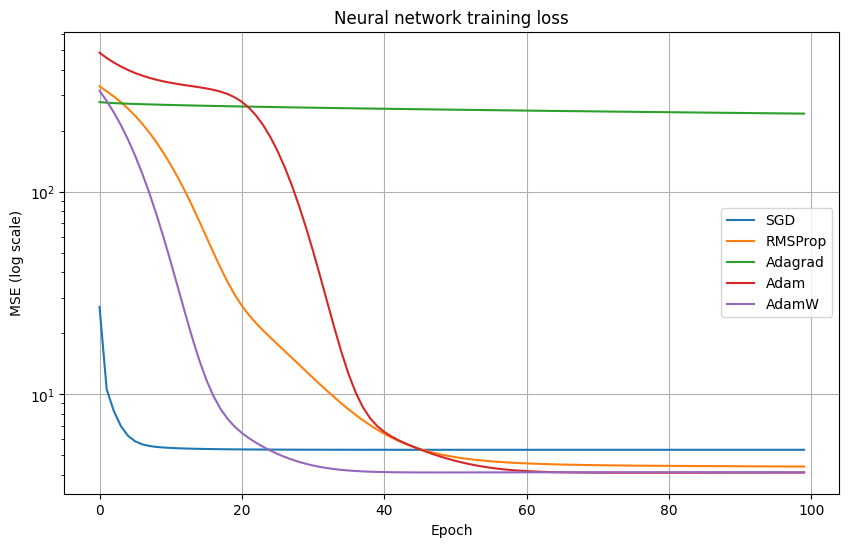

In [27]:
plot_nn_results(results=results)

Une fois de plus, l'optimiseur `Adagrad` n'arrive pas à converger. `SGD` converge vite mais la loss reste quand même élevée, tandis que `RMSProp`, `Adam` et `AdamW` arrivent à faire converger le réseau pour ainsi obtenir une loss très basse.

On retiendra ici la valeur de la loss au bout de 100 epochs pour l'optimiseur `Adam` à **4.0962**, ce qui nous sera utile pour la prochaine partie.

## Implémentation des scheduler de taux d’apprentissage

### LRScheduler

On retrouvera ici l'implémentation de la classe abstraite `LRScheduler`.

In [28]:
class LRScheduler(ABC):
    def __init__(self, optimizer: Optimizer, initial_lr: float):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.current_lr = initial_lr

    @abstractmethod
    def step(self, epoch: int | None = None):
        pass

    def get_lr(self):
        return self.optimizer.lr

    def set_lr(self, lr: float):
        self.current_lr = lr
        self.optimizer.lr = lr

### LRSchedulerOnPlateau

On retrouvera ici l'implémentation du scheduler `LRSchedulerOnPlateau`.

Dans cet algorithme, on va comparer une métrique que l'on suit à chaque epoch (typiquement la loss) avec celle qu'on a enregistré comme la meilleure au cours de l'entraînement.\
Si notre nouvelle métrique est meilleure (dépend du mode *min* ou *max*, ainsi que du *treshold*), on va actualiser notre nouvelle meilleure métrique avec cette valeur et remettre le compteur de "mauvais epoch" à 0.\
Dans le cas où notre nouvelle métrique n'est pas assez bonne, on va actualiser un compteur de "mauvais epoch".\
Si le compteur de "mauvais epoch" arrive à la valeur *patience*, on va alors modifier le learning rate en le multipliant par *factor*, tant que celui-ci n'atteint pas la valeur minimale de *min_lr*.

In [29]:
class LRSchedulerOnPlateau(LRScheduler):
    def __init__(self, optimizer: Optimizer, initial_lr: float, patience: int = 10, factor: float = 0.1, min_lr: float = 1e-6, mode: str = "min", threshold: float = 1e-4):
        if mode not in ('min', 'max'):
            raise ValueError("SchedulerOnPlateau mode should be max or min")
        super().__init__(optimizer, initial_lr)
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.mode = mode
        self.threshold = threshold

        self.num_bad_epochs = 0
        self.best = float('inf') if mode == "min" else float('-inf')

        # mode comparision
        self.is_better = lambda a, b: a < b if mode == "min" else a > b

    def step(self, new_metric):
        if self.is_better(new_metric, self.best * (1 - self.threshold if self.mode == "min" else 1 + self.threshold)):
            self.best = new_metric
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            self.num_bad_epochs = 0
            old_lr = self.current_lr
            new_lr = max(self.current_lr * self.factor, self.min_lr)

            if new_lr != self.current_lr:
                self.set_lr(new_lr)
                print(f"Reducing learning rate from {old_lr} to {new_lr}")

Dans la fonction *scheduler_eval*, on va entraîner notre réseau de neurones avec le `LRSchedulerOnPlateau` et l'optimiseur `Adam`, tout en enregistrant au fil des epochs la train loss et la val loss.

In [30]:
def scheduler_eval():
    # init -> random network parameters
    W1 = Tensor(np.random.randn())
    b1 = Tensor(np.random.randn())
    W2 = Tensor(np.random.randn())
    b2 = Tensor(np.random.randn())

    initial_lr = 0.01
    n_epochs = 200
    patience = 10

    history = {
        'train_loss': [],
        'learning_rates': [],
        'validation_loss': []
    }

    optimizer = Adam([W1, b1, W2, b2], lr=initial_lr)
    scheduler = LRSchedulerOnPlateau(
        optimizer=optimizer,
        initial_lr=initial_lr,
        patience=patience,
        factor=0.5,
        min_lr=1e-5,
        mode="min",
        threshold=1e-4
    )

    x_train, x_val, y_train, y_val = train_test_split(x_linear, y_linear, test_size=0.33, random_state=42)

    print(f"Initial lr: {optimizer.lr}\n")
    for epoch in range(n_epochs):
        epoch_loss = 0

        for x, y in zip(x_train, y_train):
            y_pred = func_nn(x, W1, b1, W2, b2)
            loss = mse(y, y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.data

        avg_train_loss = epoch_loss / len(x_train)
        history['train_loss'].append(avg_train_loss)

        val_loss = 0
        for x, y in zip(x_val, y_val):
            y_pred = func_nn(x, W1, b1, W2, b2)
            loss = mse(y, y_pred)

            val_loss += loss.data

        avg_val_loss = val_loss / len(x_val)
        history['validation_loss'].append(avg_val_loss)

        scheduler.step(avg_val_loss)
        history['learning_rates'].append(scheduler.get_lr())

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {(epoch + 1)}/{n_epochs} | train_loss: {avg_train_loss:.4f}, "
                f"val_loss: {avg_val_loss:.4f}, lr: {scheduler.get_lr():.6f}"
            )

    return history

La fonction *plot_training_history* va nous permettre d'afficher les résultats de notre entraînement avec le `LRSchedulerOnPlateau`.

In [31]:
def plot_training_history(history):
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['train_loss'], label='Training loss')
    ax1.plot(history['validation_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax1.set_yscale('log')

    ax2.plot(history['learning_rates'], label='Learning rate', color='g')
    ax2.set_title('Learning rate schedule')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.legend()
    ax2.grid(True)
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

In [32]:
history = scheduler_eval()

Initial lr: 0.01

Epoch 10/200 | train_loss: 4.1602, val_loss: 4.5774, lr: 0.010000
Epoch 20/200 | train_loss: 4.1791, val_loss: 4.6874, lr: 0.010000
Reducing learning rate from 0.01 to 0.005
Epoch 30/200 | train_loss: 4.0989, val_loss: 4.5172, lr: 0.005000
Reducing learning rate from 0.005 to 0.0025
Epoch 40/200 | train_loss: 4.0455, val_loss: 4.4544, lr: 0.002500
Reducing learning rate from 0.0025 to 0.00125
Epoch 50/200 | train_loss: 4.0156, val_loss: 4.4336, lr: 0.001250
Epoch 60/200 | train_loss: 4.0168, val_loss: 4.4334, lr: 0.001250
Reducing learning rate from 0.00125 to 0.000625
Epoch 70/200 | train_loss: 4.0000, val_loss: 4.4251, lr: 0.000625
Reducing learning rate from 0.000625 to 0.0003125
Epoch 80/200 | train_loss: 3.9916, val_loss: 4.4245, lr: 0.000313
Epoch 90/200 | train_loss: 3.9916, val_loss: 4.4216, lr: 0.000313
Reducing learning rate from 0.0003125 to 0.00015625
Epoch 100/200 | train_loss: 3.9916, val_loss: 4.4213, lr: 0.000156
Epoch 110/200 | train_loss: 3.9873, val

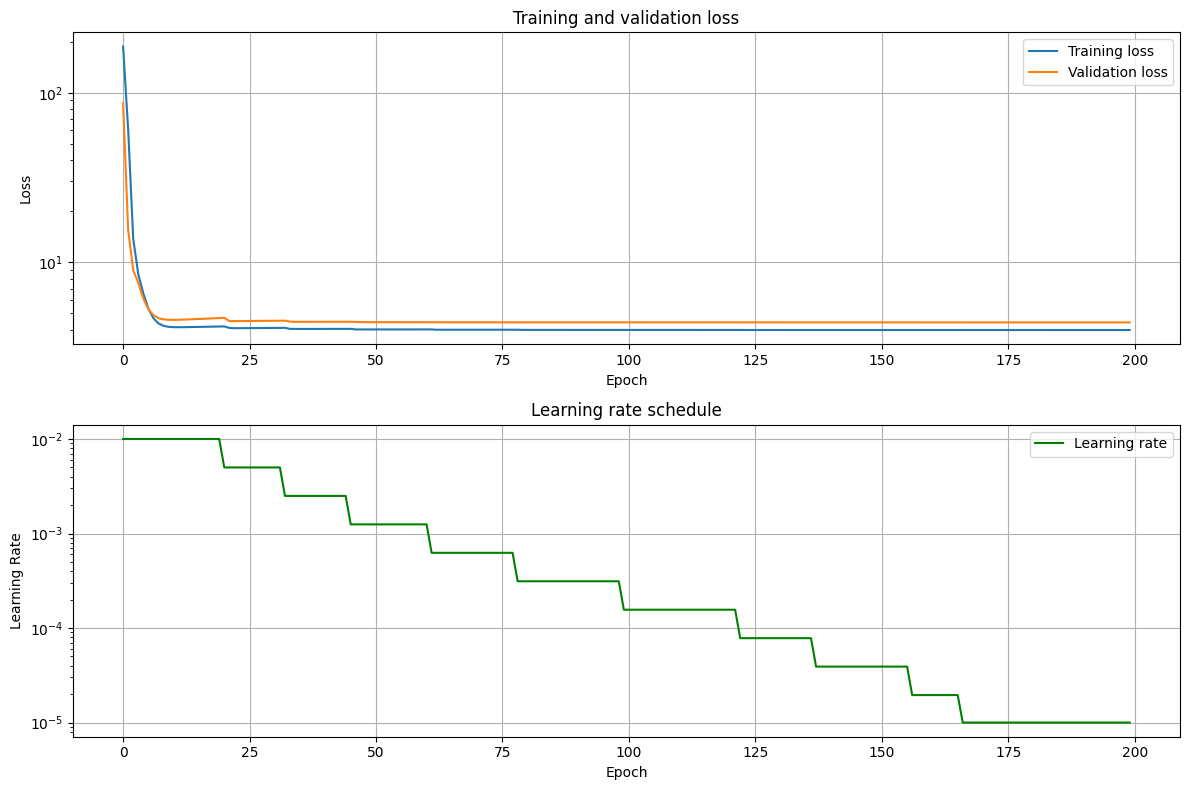

In [33]:
plot_training_history(history)

On remarque que le `LRSchedulerOnPlateau` fait bien son travail ! Avec moins de données qu'avant (car on définit ici un set de validation), notre réseau de neurone arrive à mieux converger grâce au scheduler.\
Dans la partie précédente **Implémentation du réseau de neurones**, avec l'optimiseur `Adam`, on a obtenu une train loss à **4.0962** au bout de 100 epochs, tandis que maintenant elle est à **3.9872** à 100 epochs, ce qui reste notable !